# Running two or more components

Now we're going to take a similar approach but this time combine the outputs of three distinct Landlab components: the diffuser, the monodirectional flow router, and the stream power incisor. For clarity, we're going to repeat the whole process from the start.

So first, let's import everything we don't already have:

In [13]:
from landlab.components import LinearDiffuser
from landlab.plot import imshow_grid
from landlab import RasterModelGrid, CLOSED_BOUNDARY, FIXED_VALUE_BOUNDARY
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
import numpy as np

from landlab.components import FlowRouter, FastscapeEroder
from landlab import load_params

from pylab import savefig

# the following line makes figures show up correctly in this document (only needed for iPython notebook)
%matplotlib inline
#%matplotlib

Completed loop 0
Completed loop 200
Completed loop 400
Completed loop 600
Completed loop 800
Completed loop 1000
Completed loop 1200
Completed loop 1400
Completed loop 1600
Completed loop 1800


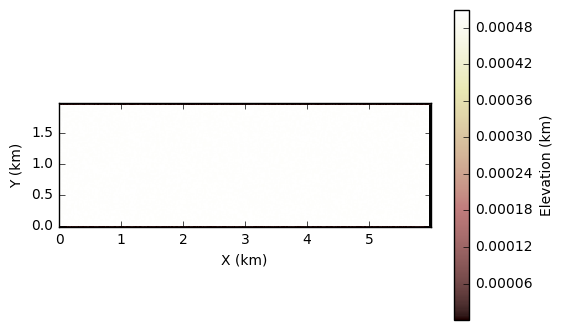

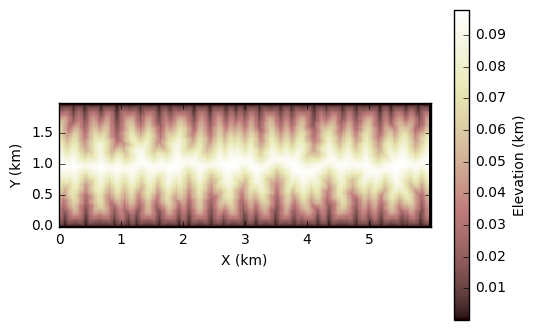

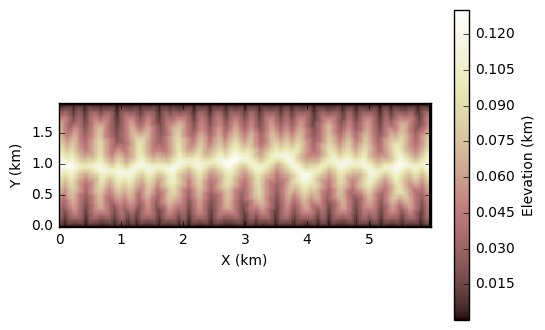

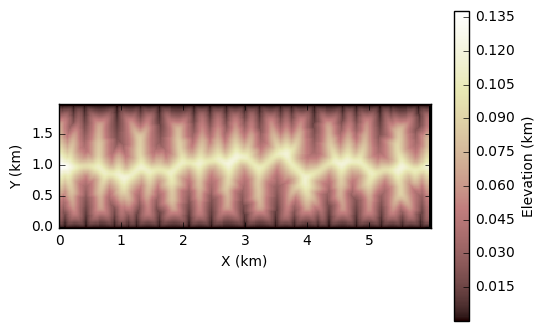

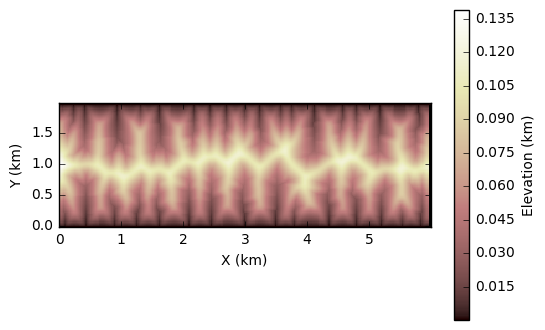

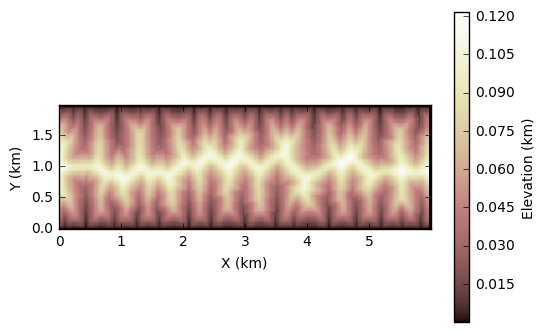

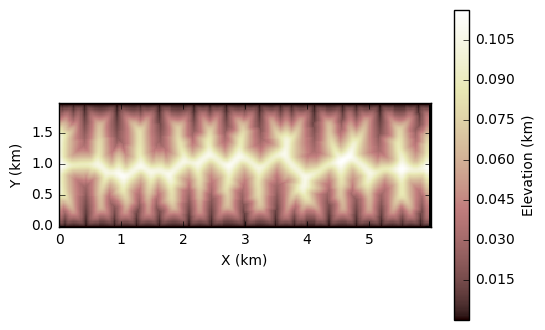

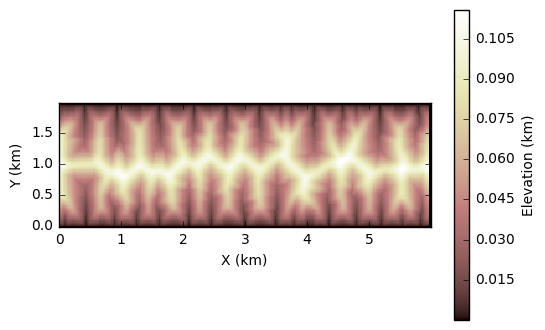

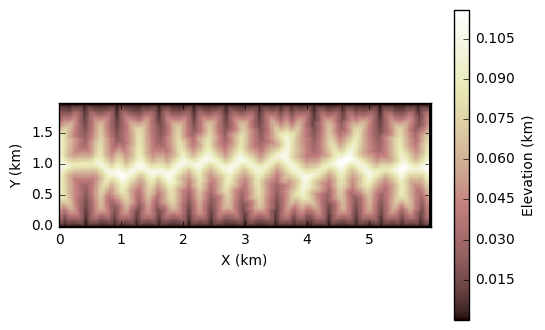

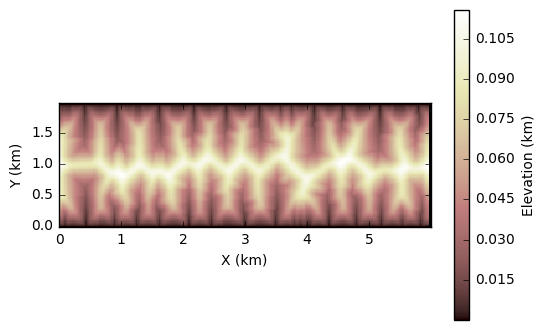

In [18]:
## Define parameters
####################

# Import parameters from a txt file
input_file = './coupled_params_celia.txt'
inputs = load_params(input_file) # load the data into a dictionary

# Write paramter from txt file
nrows = inputs['nrows'] # Nombre de ligne
ncols = inputs['ncols'] # Nombre de colonne
dx = inputs['dx'] # Espacement dans les deux directions [m]
uplift_rate = inputs['uplift_rate'] #[m/s]
total_t = inputs['total_time']
dt = inputs['dt']

#Set parameters for modelisation
nt = int(total_t // dt) #this is how many loops we'll need
uplift_per_step = uplift_rate * dt

# Now instantiate the grid, set the initial conditions, and set the boundary conditions:
mg = RasterModelGrid((nrows, ncols), dx)
z = mg.add_zeros('node', 'topographic__elevation')
# add some roughness, as this lets "natural" channel planforms arise
initial_roughness = np.random.rand(z.size)/100000.
z += initial_roughness
for edge in (mg.nodes_at_left_edge, mg.nodes_at_right_edge):
    mg.status_at_node[edge] = CLOSED_BOUNDARY
for edge in (mg.nodes_at_top_edge, mg.nodes_at_bottom_edge):
    mg.status_at_node[edge] = FIXED_VALUE_BOUNDARY
    
# instantiate components
fr = FlowRouter(mg, **inputs)
sp = FastscapeEroder(mg, **inputs)
lin_diffuse = LinearDiffuser(mg, **inputs) 


# run
z[:] = initial_roughness
#figure('topo with diffusion')
for i in range(nt):
    lin_diffuse.run_one_step(dt)  # no diffusion this time
    fr.run_one_step() # route_flow isn't time sensitive, so it doesn't take dt as input
    sp.run_one_step(dt)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    if i % 200 == 0:
        print ('Completed loop %d' % i)
        figure()
        imshow_grid(mg, 'topographic__elevation', grid_units=['km','km'], var_name='Elevation (km)')
        savefig('topo%d.jpg' % i )

# plot
#figure('topo with diffusion')
#imshow_grid(mg, 'topographic__elevation', grid_units=['km','km'],
            #var_name='Elevation (km)')